In [60]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

In [11]:
pip install tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx 
        self.Nt = Nt 
        self.init_state = init_state
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data
    

    def KPS_Solution(self, dwt) -> Tuple[np.ndarray, np.ndarray]:
        
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

  
        dut = np.random.normal(0, np.sqrt(dt**3 / 3), (self.Nt, self.Nx))

        for i in range(1, self.Nt + 1):
            xi = x_data[i - 1]
            dW = dwt[i - 1]
            dU = dut[i - 1]
            b = self.bxt(xi)
            sigma = self.sigmaxt(xi) 
            sigma_x = self.sigmaxt_x(xi) 
            sigma_xx = self.sigmaxt_xx(xi) 
            b_x = self.bxt_x(xi)  
            b_xx = self.bxt_xx(xi) 
            term1 = b * dt
            term2 = sigma * dW
            term3 = 0.5 * sigma * sigma_x * (dW**2 - dt)
            term4 = sigma * b_x * dU
            term5 = 0.5 * (b * b_x + 0.5 * sigma**2 * b_xx) * dt**2
            term6 = (b * sigma_x + 0.5 * sigma ** 2 * sigma_xx) * (dW * dt - dU)
            term7 = 0.5 * sigma * (sigma_x**2 + sigma * sigma_xx) * (dW**2 / 3 - dt) * dW
            x_data[i] = xi + term1 + term2 + term3 + term4 + term5 + term6 + term7

        return t_data, x_data

class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [15]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

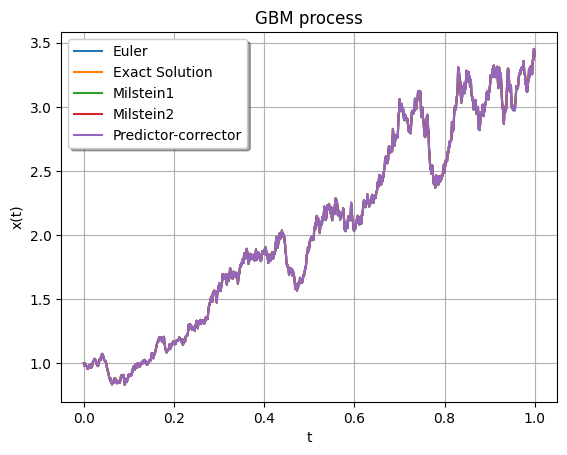

In [16]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 1. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


Task 2. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



Maximum Absolute Differences for Each Approximation Method:
                Method  Max Absolute Difference
0                Euler                10.882472
1         Milstein-1st                12.016757
2         Milstein-2nd                13.156516
3                  KPS                11.371003
4  Predictor-Corrector                12.487084


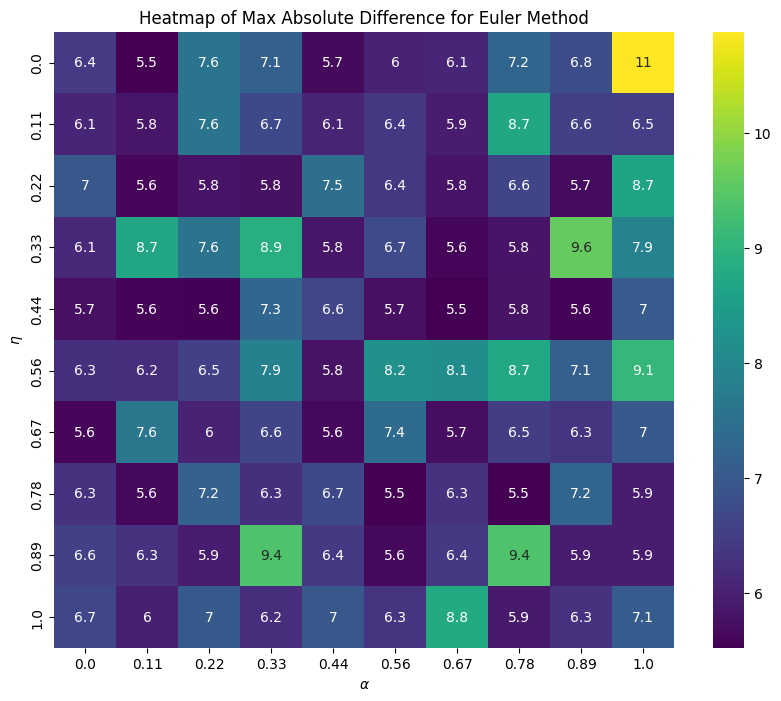

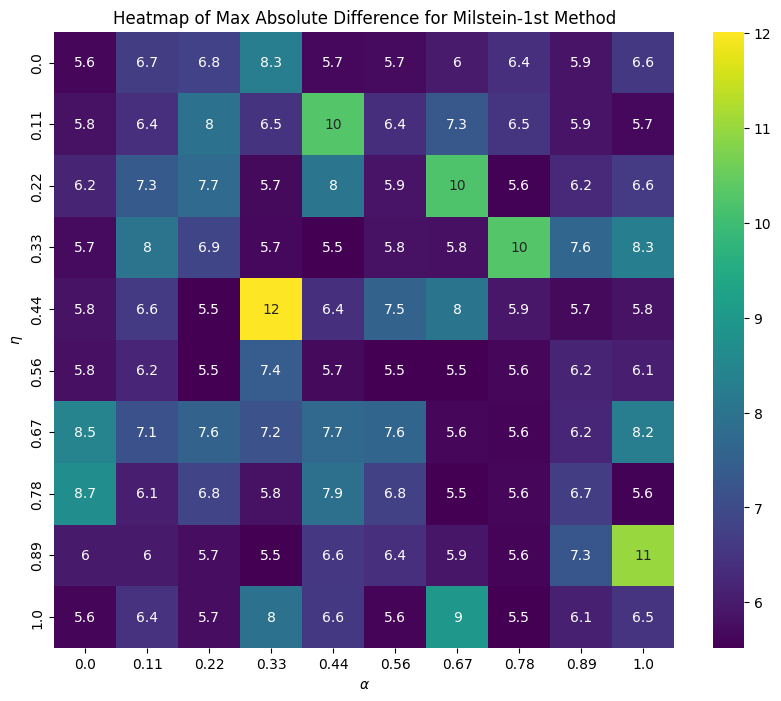

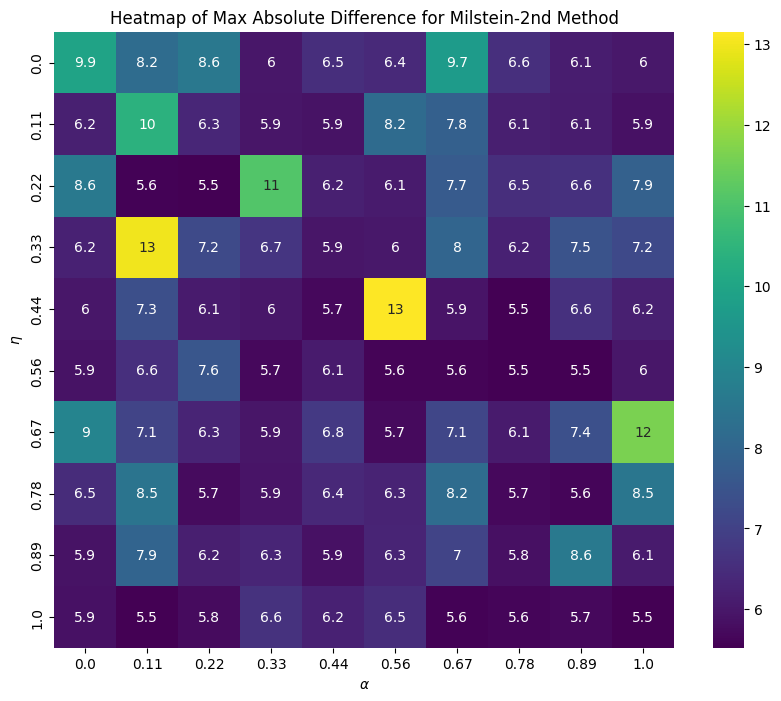

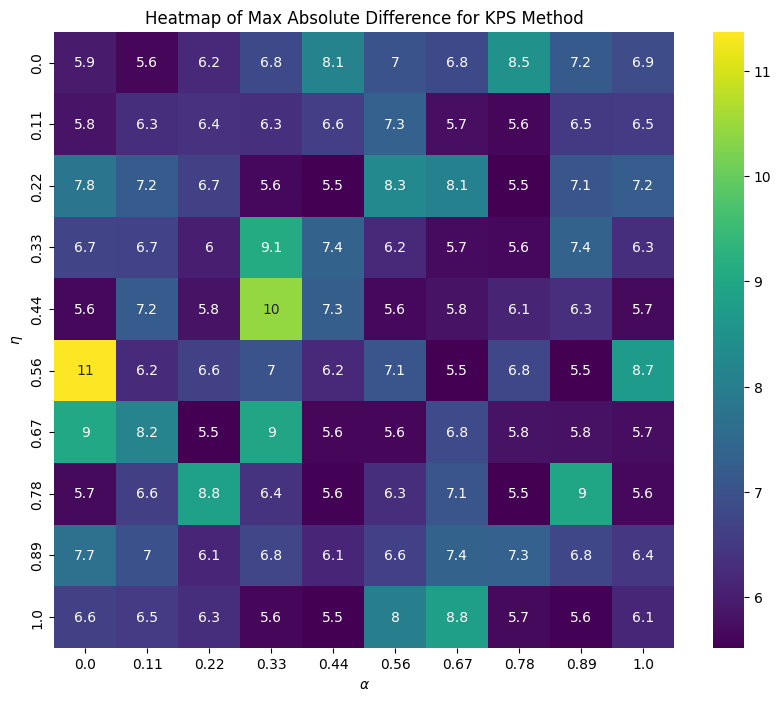

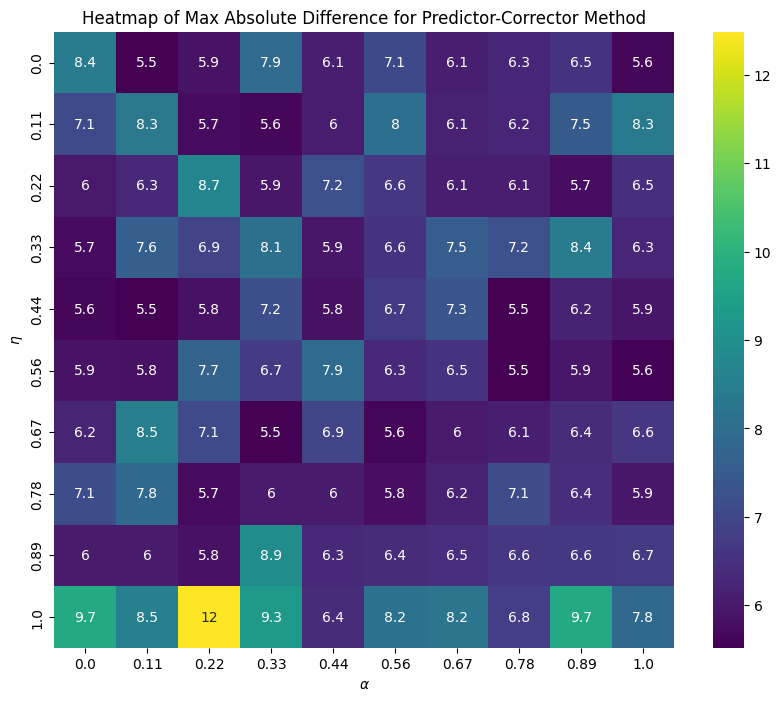

In [31]:
T = 1
theta1, theta2 = 2, 0.5
x0 = 1
N = 1024  
alpha_values = np.linspace(0, 1, 10)
eta_values = np.linspace(0, 1, 10)


def exact_solution(T, W):
    return x0 * np.exp((theta1 - 0.5 * theta2 ** 2) * T + theta2 * W)

def euler_scheme(N):
    dt = T / N
    W = np.random.normal(0, np.sqrt(dt), N).cumsum()
    W = np.insert(W, 0, 0)
    X = np.zeros(N + 1)
    X[0] = x0
    for i in range(1, N + 1):
        X[i] = X[i-1] + theta1 * X[i-1] * dt + theta2 * X[i-1] * (W[i] - W[i-1])
    exact_X = exact_solution(T, W)
    return X, exact_X

def milstein_1st(N):
    dt = T / N
    W = np.random.normal(0, np.sqrt(dt), N).cumsum()
    W = np.insert(W, 0, 0)
    X = np.zeros(N + 1)
    X[0] = x0
    for i in range(1, N + 1):
        X[i] = X[i-1] + theta1 * X[i-1] * dt + theta2 * X[i-1] * (W[i] - W[i-1]) \
               + 0.5 * theta2 ** 2 * X[i-1] * ((W[i] - W[i-1]) ** 2 - dt)
    exact_X = exact_solution(T, W)
    return X, exact_X

def milstein_2nd(N):
    dt = T / N
    W = np.random.normal(0, np.sqrt(dt), N).cumsum()
    W = np.insert(W, 0, 0)
    X = np.zeros(N + 1)
    X[0] = x0
    for i in range(1, N + 1):
        dW = W[i] - W[i-1]
        X[i] = X[i-1] + theta1 * X[i-1] * dt + theta2 * X[i-1] * dW \
               + 0.5 * theta2 ** 2 * X[i-1] * (dW ** 2 - dt) \
               + (1 / 6) * theta2 ** 3 * X[i-1] * (dW ** 3 - 3 * dW * dt)
    exact_X = exact_solution(T, W)
    return X, exact_X

def kps_method(N):
    dt = T / N
    W = np.random.normal(0, np.sqrt(dt), N).cumsum()
    W = np.insert(W, 0, 0)
    X = np.zeros(N + 1)
    X[0] = x0
    for i in range(1, N + 1):
        dW = W[i] - W[i-1]
        X[i] = X[i-1] + theta1 * X[i-1] * dt + theta2 * X[i-1] * dW \
               + 0.5 * theta2 ** 2 * X[i-1] * (dW ** 2 - dt)
    exact_X = exact_solution(T, W)
    return X, exact_X

def predictor_corrector(N, alpha=0.5, eta=0.5):
    dt = T / N
    W = np.random.normal(0, np.sqrt(dt), N).cumsum()
    W = np.insert(W, 0, 0)
    X = np.zeros(N + 1)
    X[0] = x0
    for i in range(1, N + 1):
        X_pred = X[i-1] + theta1 * X[i-1] * dt + theta2 * X[i-1] * (W[i] - W[i-1])
        X[i] = X[i-1] + (alpha * theta1 * X[i-1] + (1 - alpha) * theta1 * X_pred) * dt \
               + (eta * theta2 * X[i-1] + (1 - eta) * theta2 * X_pred) * (W[i] - W[i-1])
    exact_X = exact_solution(T, W)
    return X, exact_X

def calculate_max_diffs(method):
    max_diffs = np.zeros((len(alpha_values), len(eta_values)))
    for i, alpha in enumerate(alpha_values):
        for j, eta in enumerate(eta_values):
            if method == 'Euler':
                X, exact_X = euler_scheme(N)
            elif method == 'Milstein-1st':
                X, exact_X = milstein_1st(N)
            elif method == 'Milstein-2nd':
                X, exact_X = milstein_2nd(N)
            elif method == 'KPS':
                X, exact_X = kps_method(N)
            elif method == 'Predictor-Corrector':
                X, exact_X = predictor_corrector(N, alpha=alpha, eta=eta)
            max_diffs[i, j] = np.max(np.abs(X - exact_X))
    return max_diffs

methods = ['Euler', 'Milstein-1st', 'Milstein-2nd', 'KPS', 'Predictor-Corrector']
heatmaps = {}
max_errors_summary = []

for method in methods:
    max_diffs = calculate_max_diffs(method)
    heatmaps[method] = max_diffs
    max_error = np.max(max_diffs)
    max_errors_summary.append((method, max_error))

max_errors_df = pd.DataFrame(max_errors_summary, columns=["Method", "Max Absolute Difference"])
print("Maximum Absolute Differences for Each Approximation Method:")
print(max_errors_df)

for method, max_diffs in heatmaps.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(max_diffs, annot=True, xticklabels=np.round(alpha_values, 2), yticklabels=np.round(eta_values, 2), cmap="viridis")
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\eta$')
    plt.title(f"Heatmap of Max Absolute Difference for {method} Method")
    plt.show()

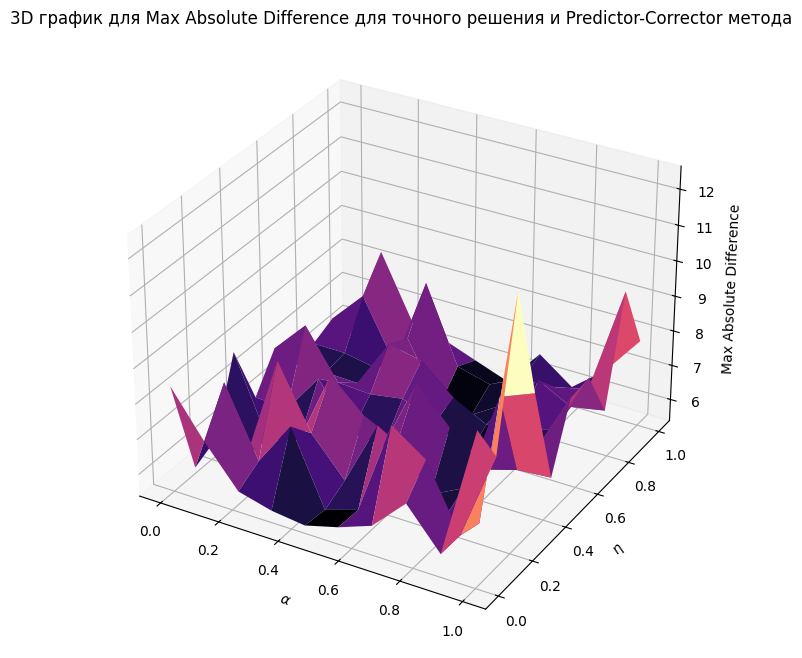

In [36]:
alpha_grid, eta_grid = np.meshgrid(alpha_values, eta_values)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, eta_grid, max_diffs.T, cmap="magma")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel('Max Absolute Difference')
ax.set_title("3D график для Max Absolute Difference для точного решения и Predictor-Corrector метода")
plt.show()

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

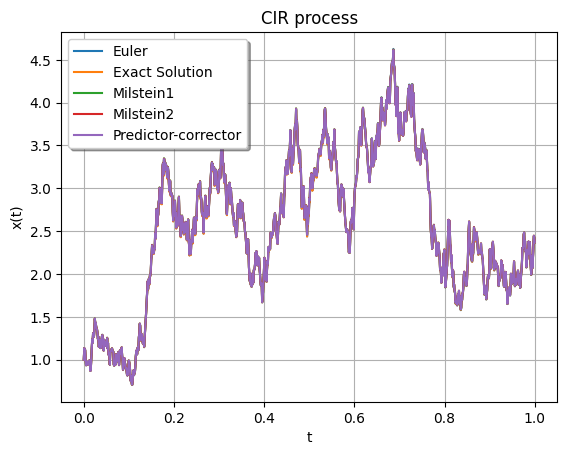

In [42]:
T = 1
Nx = 1
Nt = 1024

theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

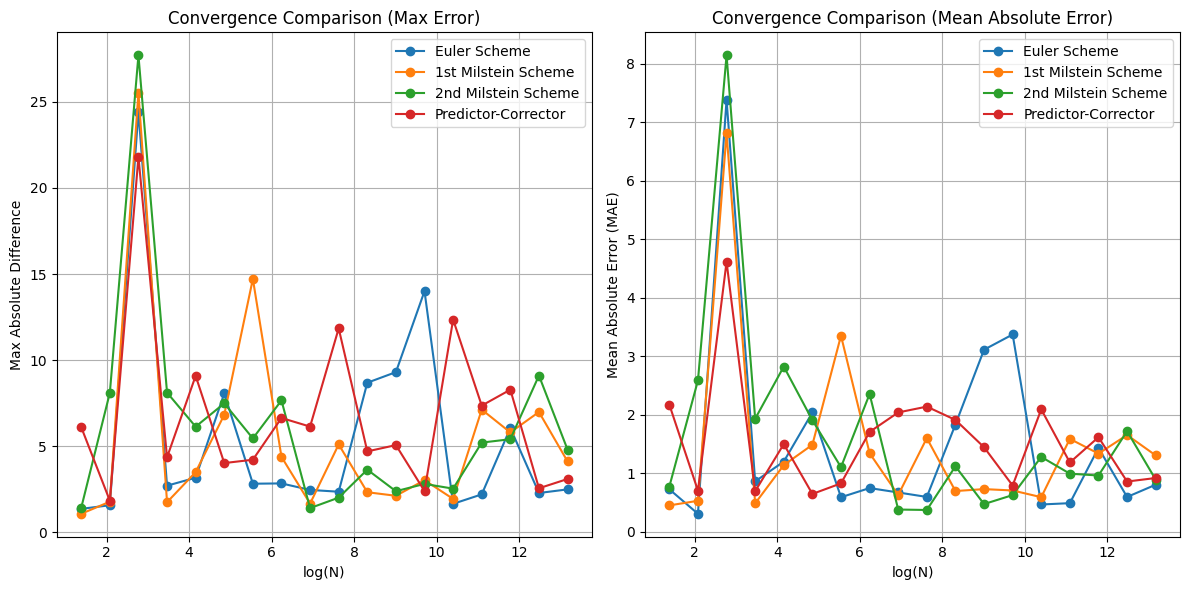

In [50]:
params = (2, 0.5)
T = 1
Nx = 1
N_values = [2 ** i for i in range(2, 20)] 
init_state = 1

process = StochasticProcess(params, T, Nx, N_values[-1], init_state)

euler_max_errors, euler_mae = [], []
milstein1_max_errors, milstein1_mae = [], []
milstein2_max_errors, milstein2_mae = [], []
predictor_corrector_max_errors, predictor_corrector_mae = [], []

for N in N_values:
    exact_X = process.ExactSolution(N)
    euler_X = process.EulerSolution(N)
    milstein1_X = process.Milstein1Solution(N)
    milstein2_X = process.Milstein2Solution(N)
    predictor_corrector_X = process.PredictorCorrectorSolution(N)
    euler_max_errors.append(np.max(np.abs(euler_X - exact_X)))
    euler_mae.append(np.mean(np.abs(euler_X - exact_X)))
    milstein1_max_errors.append(np.max(np.abs(milstein1_X - exact_X)))
    milstein1_mae.append(np.mean(np.abs(milstein1_X - exact_X)))
    milstein2_max_errors.append(np.max(np.abs(milstein2_X - exact_X)))
    milstein2_mae.append(np.mean(np.abs(milstein2_X - exact_X)))
    predictor_corrector_max_errors.append(np.max(np.abs(predictor_corrector_X - exact_X)))
    predictor_corrector_mae.append(np.mean(np.abs(predictor_corrector_X - exact_X)))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.log(N_values), euler_max_errors, label="Euler Scheme", marker='o')
plt.plot(np.log(N_values), milstein1_max_errors, label="1st Milstein Scheme", marker='o')
plt.plot(np.log(N_values), milstein2_max_errors, label="2nd Milstein Scheme", marker='o')
plt.plot(np.log(N_values), predictor_corrector_max_errors, label="Predictor-Corrector", marker='o')
plt.xlabel("log(N)")
plt.ylabel("Max Absolute Difference")
plt.title("Convergence Comparison (Max Error)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.log(N_values), euler_mae, label="Euler Scheme", marker='o')
plt.plot(np.log(N_values), milstein1_mae, label="1st Milstein Scheme", marker='o')
plt.plot(np.log(N_values), milstein2_mae, label="2nd Milstein Scheme", marker='o')
plt.plot(np.log(N_values), predictor_corrector_mae, label="Predictor-Corrector", marker='o')
plt.xlabel("log(N)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Convergence Comparison (Mean Absolute Error)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [51]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

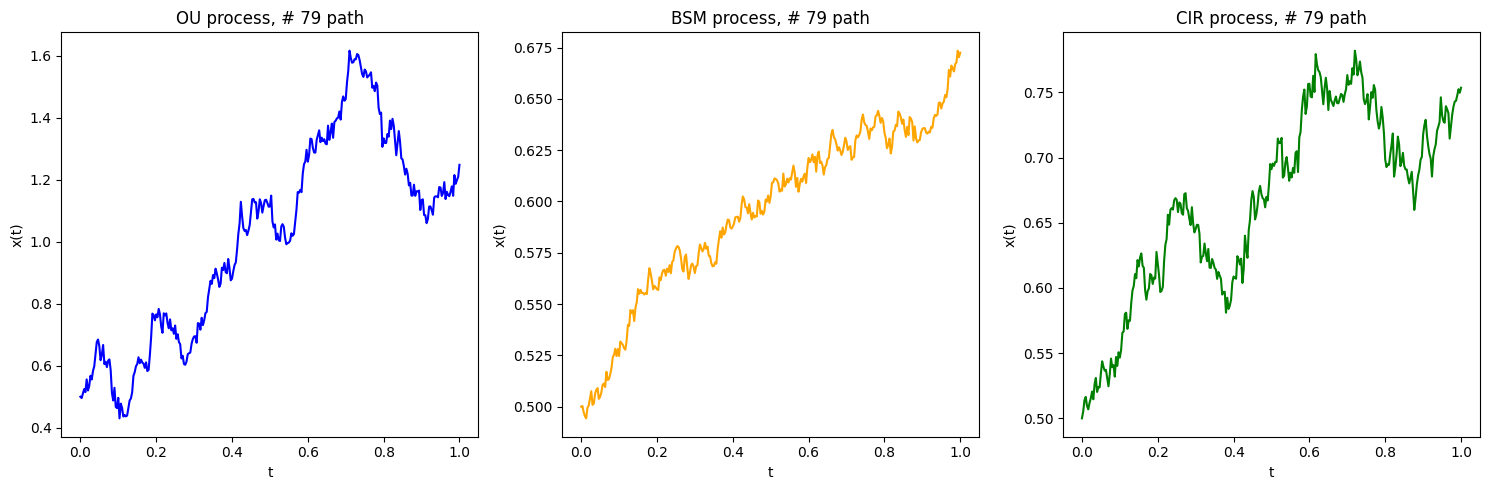

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

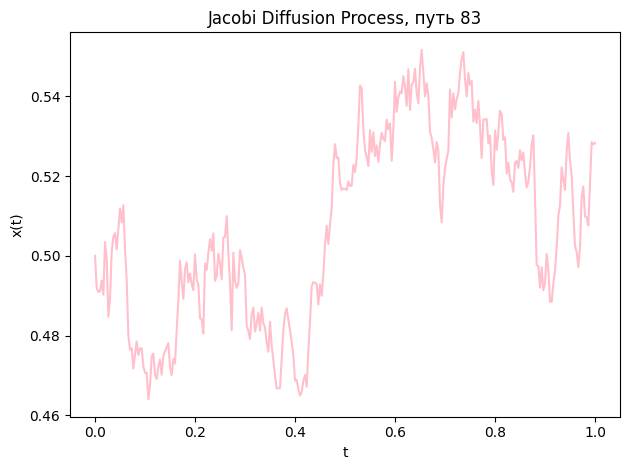

In [61]:
class JacobiProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.dt = T / Nt
        self.init_state = init_state if init_state is not None else self.DefaultInitState()

    def DefaultInitState(self):
        return np.full(self.Nx, 0.5)

    def PathGenerator(self):
        kappa, theta, sigma = self.params
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))
        x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_prev = x_data[i - 1]
            drift = kappa * (theta - x_prev) * self.dt
            diffusion = sigma * np.sqrt(np.maximum(x_prev * (1 - x_prev), 0)) * np.random.normal(0, np.sqrt(self.dt), self.Nx)
            x_data[i] = np.clip(x_prev + drift + diffusion, 0, 1) 
            
        return t_data, x_data

Nx = 100
Nt = 300
T = 1
params_Jacobi = [2.0, 0.5, 0.2]  
init_state = 0.5 * np.ones(Nx)  

jacobi_process = JacobiProcess(params_Jacobi, T, Nx, Nt, init_state)
t_data, x_data_Jacobi = jacobi_process.PathGenerator()
n = np.random.randint(0, Nx)
plt.plot(t_data, x_data_Jacobi[:, n], color='pink')
plt.title(f'Jacobi Diffusion Process, путь {n}')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

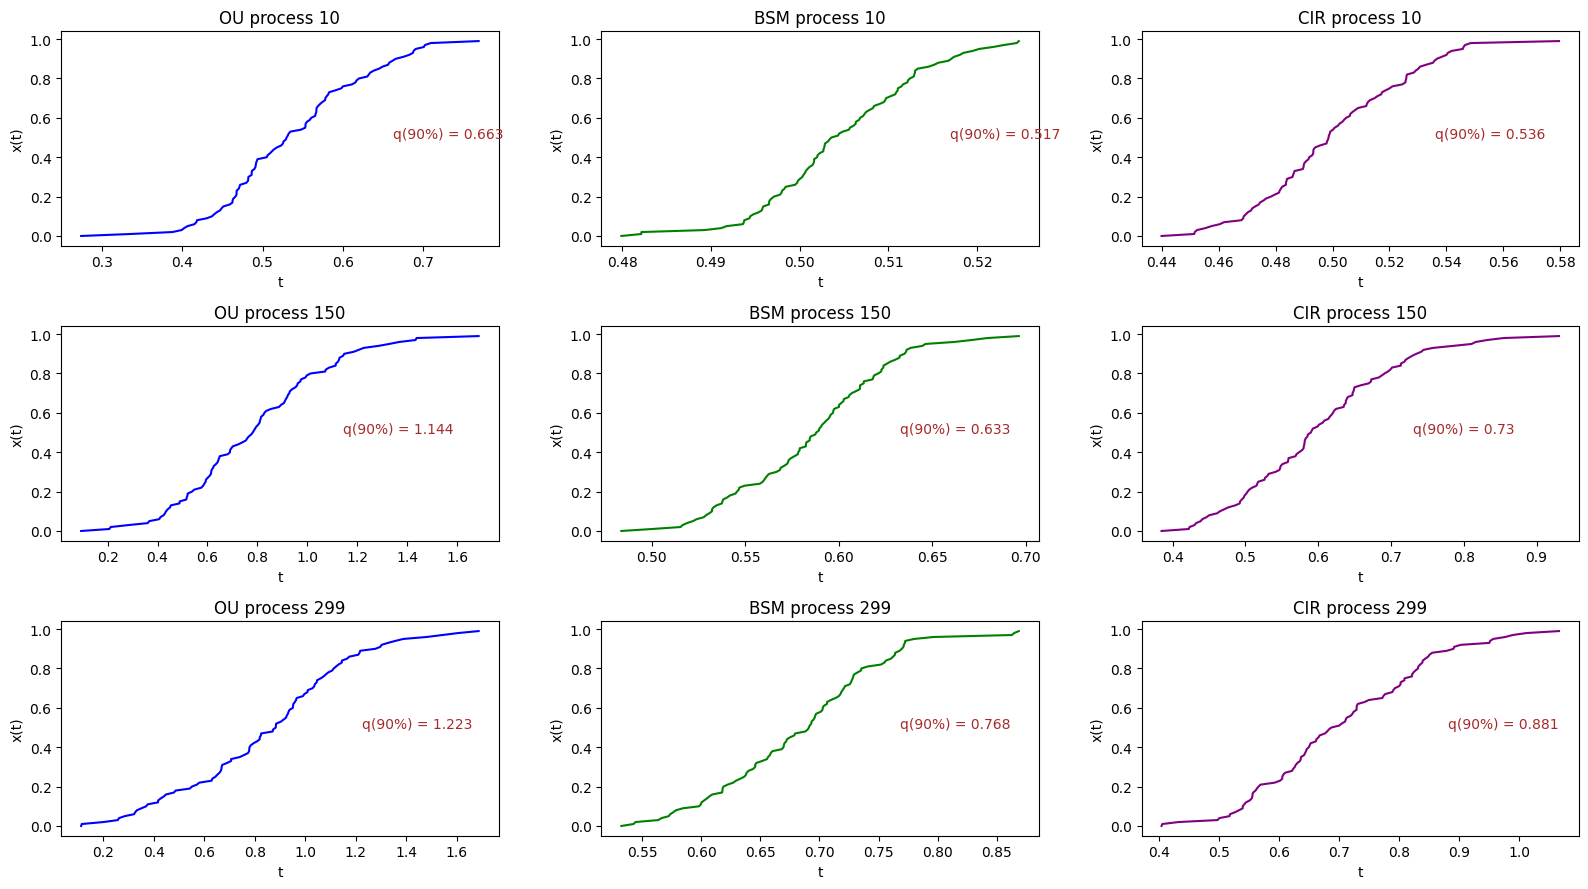

In [ ]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

KS statistic: 0.242, P-value: 4.2252283893369713e-26


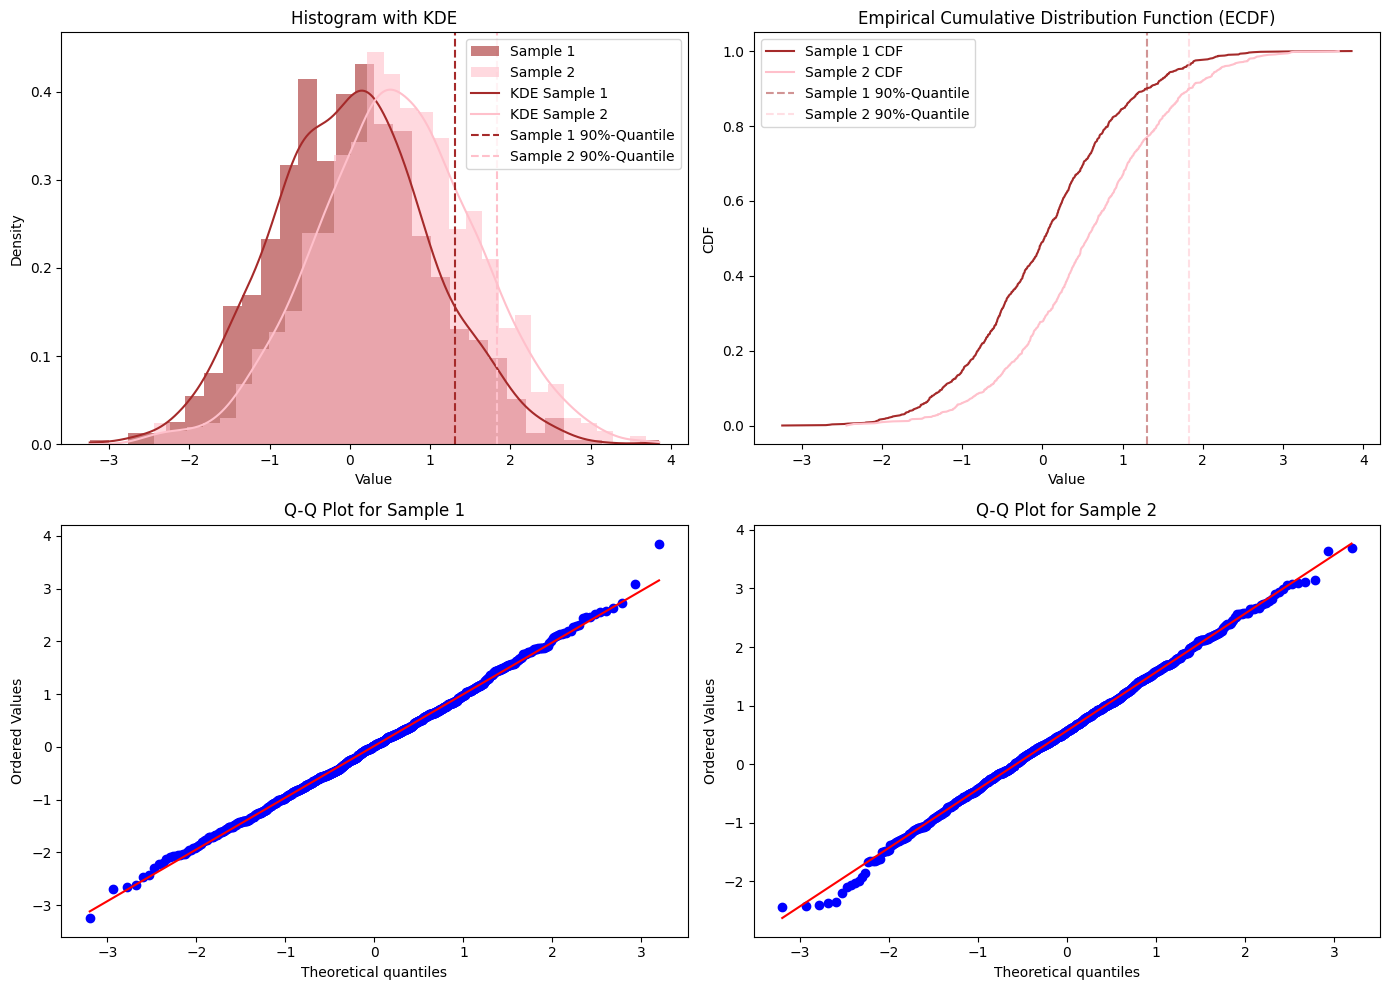

Заключение: выборки статистически различимы на уровне значимости 0.05.


In [76]:
from scipy.stats import ks_2samp, gaussian_kde, probplot

np.random.seed(42)
sample1 = np.random.normal(loc=0, scale=1, size=1000)  
sample2 = np.random.normal(loc=0.5, scale=1, size=1000) 

ks_stat, p_value = ks_2samp(sample1, sample2)
print(f"KS statistic: {ks_stat}, P-value: {p_value}")

quantile_90_sample1 = np.quantile(sample1, 0.9)
quantile_90_sample2 = np.quantile(sample2, 0.9)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].hist(sample1, bins=30, density=True, alpha=0.6, color='brown', label='Sample 1')
axs[0, 0].hist(sample2, bins=30, density=True, alpha=0.6, color='pink', label='Sample 2')
kde1 = gaussian_kde(sample1)
kde2 = gaussian_kde(sample2)
x_vals = np.linspace(min(min(sample1), min(sample2)), max(max(sample1), max(sample2)), 1000)
axs[0, 0].plot(x_vals, kde1(x_vals), color='brown', linestyle='-', label='KDE Sample 1')
axs[0, 0].plot(x_vals, kde2(x_vals), color='pink', linestyle='-', label='KDE Sample 2')
axs[0, 0].axvline(quantile_90_sample1, color='brown', linestyle='--', label='Sample 1 90%-Quantile')
axs[0, 0].axvline(quantile_90_sample2, color='pink', linestyle='--', label='Sample 2 90%-Quantile')
axs[0, 0].set_title('Histogram with KDE')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

sorted_sample1 = np.sort(sample1)
sorted_sample2 = np.sort(sample2)
cdf1 = np.arange(1, len(sorted_sample1) + 1) / len(sorted_sample1)
cdf2 = np.arange(1, len(sorted_sample2) + 1) / len(sorted_sample2)
axs[0, 1].plot(sorted_sample1, cdf1, label="Sample 1 CDF", color='brown')
axs[0, 1].plot(sorted_sample2, cdf2, label="Sample 2 CDF", color='pink')
axs[0, 1].axvline(quantile_90_sample1, color='brown', linestyle='--', alpha=0.5, label='Sample 1 90%-Quantile')
axs[0, 1].axvline(quantile_90_sample2, color='pink', linestyle='--', alpha=0.5, label='Sample 2 90%-Quantile')
axs[0, 1].set_title('Empirical Cumulative Distribution Function (ECDF)')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('CDF')
axs[0, 1].legend()

probplot(sample1, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot for Sample 1')
probplot(sample2, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot for Sample 2')
plt.tight_layout()
plt.show()

if p_value < 0.05:
    print("Заключение: выборки статистически различимы на уровне значимости 0.05.")
else:
    print("Заключение: выборки не статистически различимы на уровне значимости 0.05.")


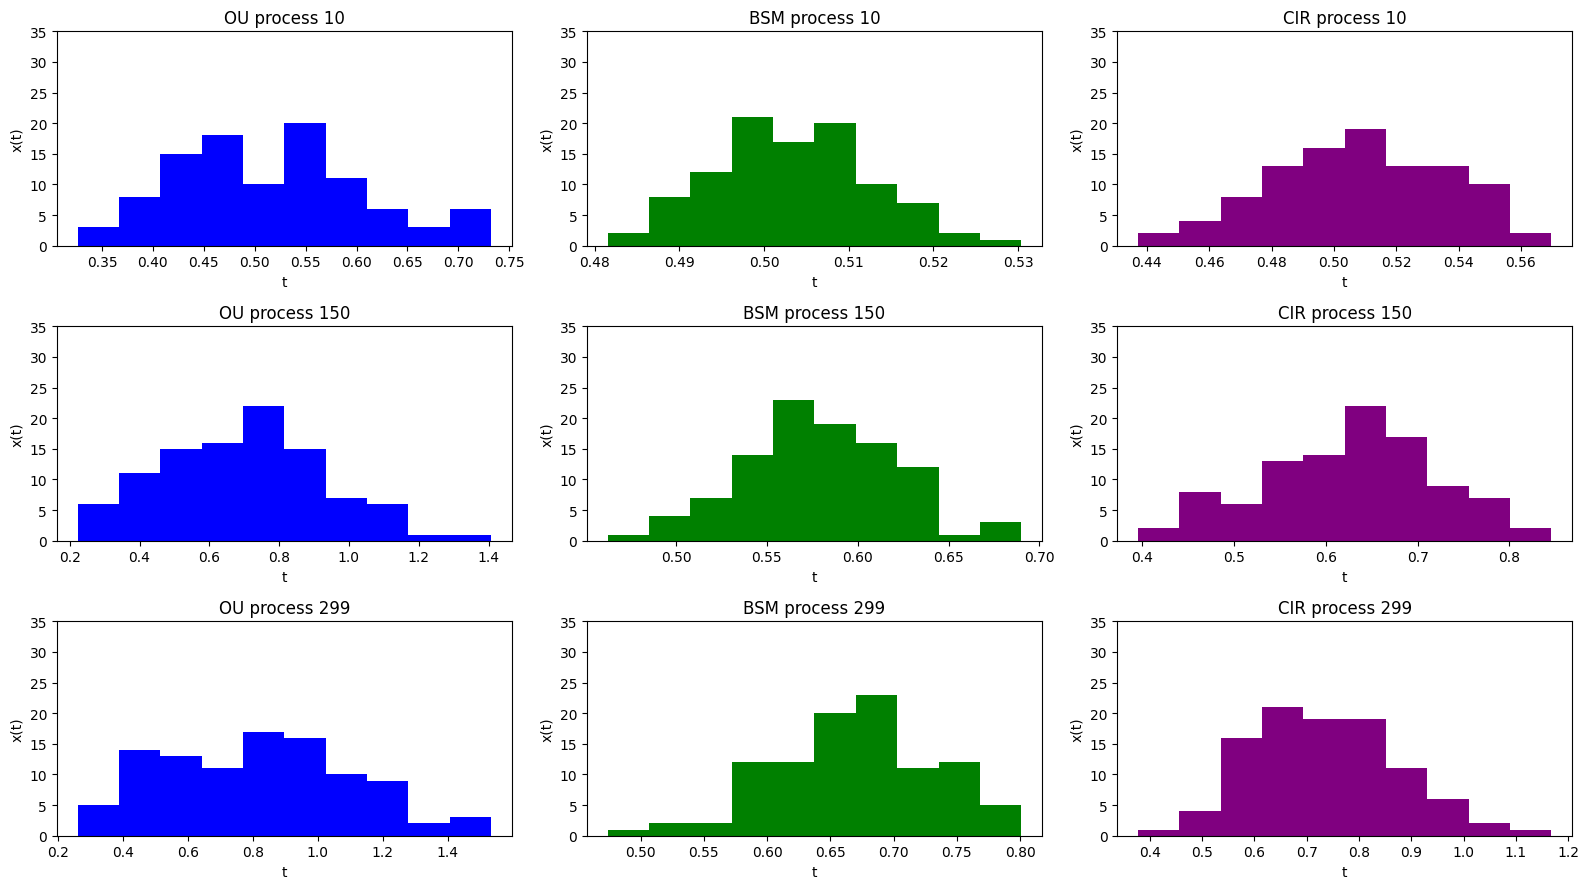

In [88]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 35)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

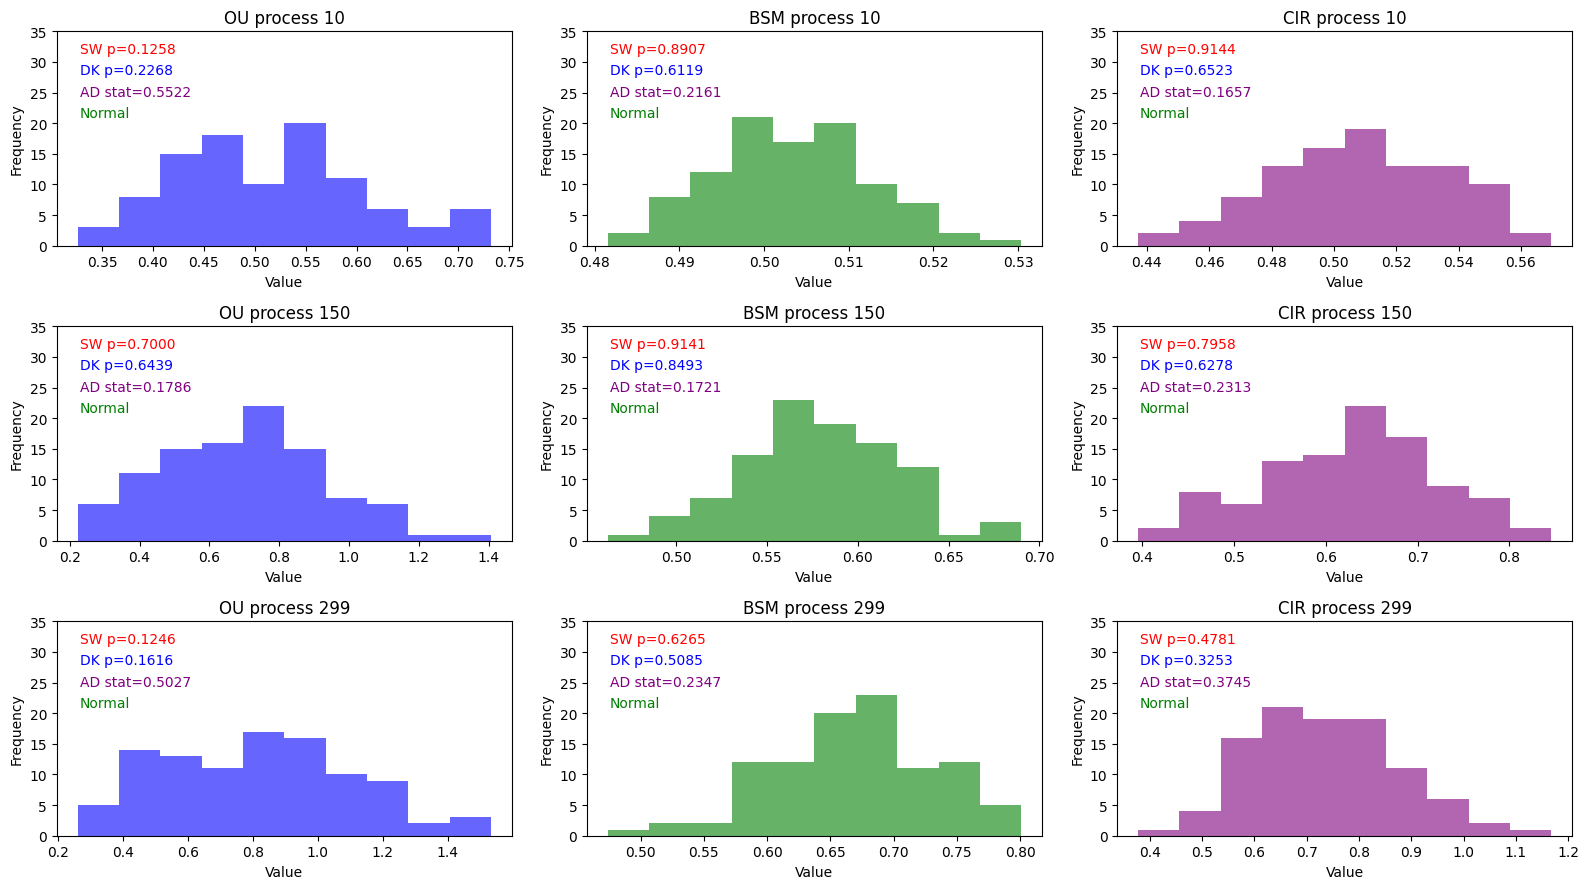

In [97]:
from scipy.stats import shapiro, normaltest, anderson

fig, axs = plt.subplots(3, 3, figsize=(16, 9))
indices = [10, Nt // 2, Nt - 1]

for row, n in enumerate(indices):
    axs[row][0].hist(x_data_OU[n], color='blue', alpha=0.6)
    axs[row][0].set_title(f'OU process {n}')
    stat, p_value = shapiro(x_data_OU[n])
    axs[row][0].text(0.05, 0.9, f'SW p={p_value:.4f}', transform=axs[row][0].transAxes, color='red')
    stat, p_value = normaltest(x_data_OU[n])
    axs[row][0].text(0.05, 0.8, f'DK p={p_value:.4f}', transform=axs[row][0].transAxes, color='blue')
    result = anderson(x_data_OU[n])
    axs[row][0].text(0.05, 0.7, f'AD stat={result.statistic:.4f}', transform=axs[row][0].transAxes, color='purple')
    axs[row][0].text(0.05, 0.6, "Non-normal" if p_value < 0.05 else "Normal", transform=axs[row][0].transAxes,
                     color='green' if p_value >= 0.05 else 'red')
    axs[row][1].hist(x_data_BSM[n], color='green', alpha=0.6)
    axs[row][1].set_title(f'BSM process {n}')
    stat, p_value = shapiro(x_data_BSM[n])
    axs[row][1].text(0.05, 0.9, f'SW p={p_value:.4f}', transform=axs[row][1].transAxes, color='red')
    stat, p_value = normaltest(x_data_BSM[n])
    axs[row][1].text(0.05, 0.8, f'DK p={p_value:.4f}', transform=axs[row][1].transAxes, color='blue')
    result = anderson(x_data_BSM[n])
    axs[row][1].text(0.05, 0.7, f'AD stat={result.statistic:.4f}', transform=axs[row][1].transAxes, color='purple')
    axs[row][1].text(0.05, 0.6, "Non-normal" if p_value < 0.05 else "Normal", transform=axs[row][1].transAxes,
                     color='green' if p_value >= 0.05 else 'red')
    axs[row][2].hist(x_data_CIR[n], color='purple', alpha=0.6)
    axs[row][2].set_title(f'CIR process {n}')
    stat, p_value = shapiro(x_data_CIR[n])
    axs[row][2].text(0.05, 0.9, f'SW p={p_value:.4f}', transform=axs[row][2].transAxes, color='red')
    stat, p_value = normaltest(x_data_CIR[n])
    axs[row][2].text(0.05, 0.8, f'DK p={p_value:.4f}', transform=axs[row][2].transAxes, color='blue')
    result = anderson(x_data_CIR[n])
    axs[row][2].text(0.05, 0.7, f'AD stat={result.statistic:.4f}', transform=axs[row][2].transAxes, color='purple')
    axs[row][2].text(0.05, 0.6, "Non-normal" if p_value < 0.05 else "Normal", transform=axs[row][2].transAxes,
                     color='green' if p_value >= 0.05 else 'red')

for k in range(3):
    for j in range(3):
        axs[k][j].set_ylim(0, 35)
        axs[k][j].set_xlabel('Value')
        axs[k][j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()